In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
h5 = pd.HDFStore("/home/pchatha/mimic/data/all_hourly_data.h5")

In [3]:
h5.keys()

['/codes',
 '/interventions',
 '/patients',
 '/vitals_labs',
 '/vitals_labs_mean',
 '/patients/meta/values_block_6/meta',
 '/patients/meta/values_block_5/meta',
 '/patients/meta/values_block_4/meta',
 '/patients/meta/values_block_0/meta']

In [4]:
interventions = h5["interventions"].reset_index()

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

### Subset to Patient Stays between 16-128 hours

In [6]:
interventions['subject_id'].nunique()

34472

In [7]:
stay_lengths = interventions.groupby("subject_id").size()
stay_lengths = stay_lengths[(stay_lengths >= 16) & (stay_lengths <= 128)]
stay_lengths.name="stay_length"

In [8]:
len(stay_lengths.index)

30323

In [9]:
stay_lengths.describe()

count    30323.000000
mean        51.071398
std         27.902553
min         16.000000
25%         28.000000
50%         45.000000
75%         69.000000
max        128.000000
Name: stay_length, dtype: float64

### Extract Treatment Status

In [10]:
interventions.groupby("subject_id")["vent"].any().mean()

0.389011371547923

In [11]:
vent = interventions.groupby("subject_id")["vent"].any().astype(int)

In [12]:
vent = vent.to_frame().join(stay_lengths, how="right")

In [13]:
vent.shape

(30323, 2)

In [14]:
vent['vent'].mean()

0.35438446064043794

In [15]:
vent.groupby("vent")["stay_length"].mean()

vent
0    46.918476
1    58.637167
Name: stay_length, dtype: float64

In [16]:
vent.head()

,vent,stay_length
subject_id,,
4,0,41
6,0,89
9,1,128
11,0,39
13,1,88


### Demographic Data

In [17]:
demog = h5["patients"]

In [18]:
demog = demog[["gender", "age"]]

In [19]:
demog["gender"].value_counts(normalize=True)

M    0.565502
F    0.434498
Name: gender, dtype: float64

In [20]:
d = {"F":0, "M":1}
demog["gender"] = demog["gender"].apply(lambda x: d.get(x))

In [21]:
demog["age"] = demog["age"].clip(upper=90)

In [22]:
demog["age"].describe()

count    34472.000000
mean        63.841678
std         17.590891
min         15.052693
25%         52.466861
50%         65.741463
75%         78.016920
max         90.000000
Name: age, dtype: float64

In [23]:
demog["age"] = (demog["age"] - demog["age"].mean()) / demog["age"].std()

In [24]:
demog["age"].describe()

count    3.447200e+04
mean     2.538682e-14
std      1.000000e+00
min     -2.773537e+00
25%     -6.466311e-01
50%      1.079982e-01
75%      8.058286e-01
max      1.487038e+00
Name: age, dtype: float64

In [25]:
demog = demog.reset_index().set_index("subject_id")[["gender", "age"]]

In [26]:
demog = demog.join(stay_lengths, how="right")

### Get ICD Data

In [27]:
codes = h5["codes"].reset_index()[["subject_id", "icd9_codes"]].drop_duplicates(["subject_id"])

In [28]:
codes = codes.set_index("subject_id").join(stay_lengths, how="right")

In [29]:
codes["icd9_codes"].apply(len).describe()

count    30323.000000
mean        10.542361
std          5.590807
min          1.000000
25%          7.000000
50%          9.000000
75%         13.000000
max         39.000000
Name: icd9_codes, dtype: float64

In [30]:
codes = codes.explode("icd9_codes")

Special ICD9 Codes:
4019: hypertension
41401: coronary atherosclerosis
42731: atrial fibrillation (all more likely in treated group)

#### Incorporate Confounding Codes

In [31]:
conf_codes = codes.copy()

In [32]:
conf_codes["hypertension"] = (conf_codes["icd9_codes"] == "4019")
conf_codes["coronary_ath"] = (conf_codes["icd9_codes"] == "41401")
conf_codes["atrial_fib"] = (conf_codes["icd9_codes"] == "42731")

In [33]:
conf_codes = conf_codes.groupby(conf_codes.index)[["hypertension", "coronary_ath", "atrial_fib"]].any().astype(int)

In [34]:
conf_codes.any(axis=1).mean()

0.6264881443128978

### Get Lab Data

In [35]:
vitals = h5["vitals_labs_mean"].droplevel(['hadm_id', 'icustay_id'])
vitals.columns = vitals.columns.get_level_values(0)

Confounding vitals: heart rate, hematocrit, platelets, hemoglobin

In [36]:
vitals_list = vitals.notna().sum(0).sort_values(ascending=False).head(25).index

In [37]:
vitals = vitals[vitals_list]

In [38]:
# vitals = vitals[vital_list]
vitals = vitals.fillna(method="ffill")
vitals = vitals.fillna(method="bfill")

In [39]:
mean = np.mean(vitals, axis=0)
std = np.std(vitals, axis=0)
vitals = (vitals - mean) / std

In [40]:
vitals = vitals.join(stay_lengths, how="right")

In [41]:
vitals.index.levels[0]

Int64Index([    4,     6,     9,    11,    13,    17,    18,    19,    20,
               22,
            ...
            99946, 99957, 99965, 99966, 99973, 99983, 99991, 99992, 99995,
            99999],
           dtype='int64', name='subject_id', length=30323)

Confounding vitals: heart rate, hematocrit, platelets, hemoglobin

In [42]:
conf_vitals = vitals[["hematocrit", "hemoglobin", "platelets", "mean blood pressure"]]

In [43]:
conf_vitals = conf_vitals.groupby(level=0).tail(3).groupby(level = 0).mean()

# Combine Everything!

In [44]:
df = demog[["gender", "stay_length"]].join(vent["vent"])

In [45]:
df["gender"] = df["gender"].astype(int)

In [46]:
df["stay_length"] = (df["stay_length"] - df["stay_length"].mean()) / df["stay_length"].std()

63% of patients have at least one of the confounding codes (good!)

In [47]:
df = df.join(conf_codes)

In [41]:
# conf_vitals = vitals[["hematocrit", "platelets", "hemoglobin", "mean blood pressure"]]

In [49]:
df = df.join(conf_vitals)

In [50]:
df.groupby(["vent"]).mean()

,gender,stay_length,hypertension,coronary_ath,atrial_fib,hematocrit,hemoglobin,platelets,mean blood pressure
vent,,,,,,,,,
0,0.535935,-0.148837,0.400368,0.203249,0.201972,0.178461,0.165666,0.079059,0.025547
1,0.624232,0.271150,0.508003,0.407873,0.280663,-0.192991,-0.150942,-0.240324,-0.265774


In [52]:
df.head()

,gender,stay_length,vent,hypertension,coronary_ath,atrial_fib,hematocrit,hemoglobin,platelets,mean blood pressure
subject_id,,,,,,,,,,
4,0,-0.360949,0,0,0,0,0.018405,-0.111641,0.413658,0.867736
6,0,1.359324,0,0,0,0,0.890256,0.933756,-0.393352,0.761607
9,1,2.757045,1,1,0,0,1.006502,1.043798,1.059265,0.740383
11,0,-0.432627,0,0,0,0,0.851507,0.988777,0.279156,-0.787850
13,0,1.323485,1,1,1,0,-0.969693,-1.046996,-0.976192,-0.759551


In [53]:
T = df["vent"].to_numpy()

In [54]:
X = df.drop(columns="vent").to_numpy()

array([0.57717352, 0.9004591 , 0.74688164, 0.74896366, 0.56343639,
       0.87217288, 1.01449824, 1.11836651, 0.68531735])

In [58]:
np.random.seed(28)
beta = np.random.uniform(0.5, 1.5, size=9)
beta = beta * [1, 1, 1, 1, 1, -1, -1, -1, -1]
beta

array([ 1.22901374,  1.0612396 ,  0.62496709,  0.89759237,  1.28130821,
       -1.01099298, -0.68269336, -1.35351288, -1.45537189])

In [48]:
X = df.drop(columns="vent").to_numpy()

In [49]:
X.shape

(30323, 8)

In [59]:
Z = (X * beta).sum(1)

In [65]:
sigmoid(Z - 1.6).mean()

0.500664274031168

In [159]:
eta = -1.8
m = .8
c = (eta * T + m*Z).mean()
p = sigmoid(eta * T + m*Z - c)

In [160]:
p.mean()

0.5043706509855685

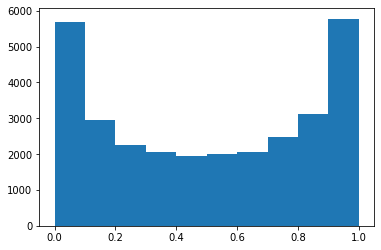

In [161]:
plt.hist(p)
plt.show()

In [154]:
p[T == 1].mean(), p[T == 0].mean()

(0.5213900180771548, 0.4950285598190883)

In [162]:
p1 = sigmoid(eta + m*Z - c)
p0 = sigmoid(m*Z - c)
p1.mean(), p0.mean()

(0.360727986960586, 0.5796624355639173)

In [163]:
y = np.random.binomial(1, p)
y0 = np.random.binomial(1, p0)
y1 = np.random.binomial(1, p1)

In [164]:
print(y[df["vent"]==1].mean(), y[df["vent"]==0].mean())
print(y1.mean(), y0.mean())

0.5236367020286619 0.4959901925729172
0.361375853312667 0.5793292220426739


In [165]:
print(p[df["vent"]==1].mean() - p[df["vent"]==0].mean())
print((y1 - y0).mean())

0.026361458258066517
-0.21795336873000692


#### Write out Data

In [166]:
df.to_csv("../data/semisynth_features.csv", index=True)

In [168]:
df["vent"].to_csv("../data/treatment_assignment.csv", index=True)

In [169]:
df_label_probs = pd.DataFrame(index=df.index)
df_label_probs["p"] = p
df_label_probs["p0"] = p0
df_label_probs["p1"] = p1

In [170]:
df_label_probs.head()

,p,p0,p1
subject_id,,,
4,0.086939,0.086939,0.015495
6,0.236892,0.236892,0.048809
9,0.118964,0.449603,0.118964
11,0.166031,0.166031,0.031860
13,0.961064,0.993348,0.961064


In [172]:
df_label_probs.to_csv("../data/outcome_probs.csv")

#### visualize

In [51]:
vitals["heart rate"].head()

subject_id  hours_in
3           0           3.340470
            1           3.956230
            2           3.039750
            3           2.552869
            4           3.512310
Name: heart rate, dtype: float64

Int64Index([    3,     4,     6,     9,    11,    12,    13,    17,    18,
               19,
            ...
            99957, 99965, 99966, 99973, 99982, 99983, 99991, 99992, 99995,
            99999],
           dtype='int64', name='subject_id', length=34472)

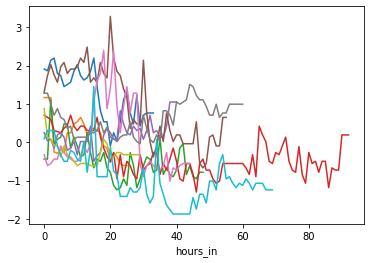

In [58]:
for i in np.random.choice(vitals.index.levels[0], 10):
    vitals["heart rate"].loc[i].plot()

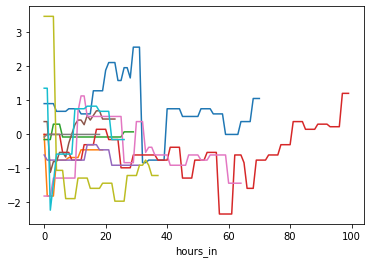

In [60]:
for i in np.random.choice(vitals.index.levels[0], 10):
    vitals["temperature"].loc[i].plot()

<AxesSubplot:xlabel='hours_in'>

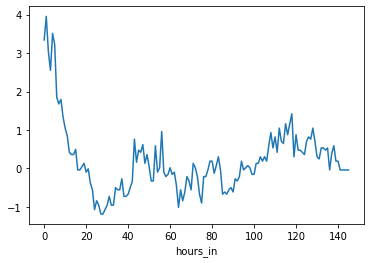

In [53]:
vitals["heart rate"].loc[3].plot()